# Racial Demographics of Oil Well Locations

## Bring in Oil Wells Data

In [322]:
# to read and wrangle data
import pandas as pd

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

In [323]:
# bring in idle wells data
wells = pd.read_csv('LAC_wells_onshore2.csv')

In [324]:
# test it
wells.head()

,LeaseName,WellNumber,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,Latitude,Longitude
0,Chanchorena,1,Plugged,OG,Oil & Gas,S1375,Steven A. Sayce,33.593762,-118.023328
1,Lease by San Pedro-Point Fermin Oil & Gas Co.,1,Plugged,DH,Dry Hole,7633,San Pedro-Point Fermin Oil & Gas Co.,33.705338,-118.293968
2,Lease by Lighthouse Oil Co.,1,Idle,OG,Oil & Gas,9707,Lighthouse Oil Co.,33.708696,-118.291480
3,Lease by Los Angeles Harbor Oil Dev. Co.,1,Idle,OG,Oil & Gas,5421,Los Angeles Harbor Oil Dev. Co.,33.716400,-118.302544
4,Sepulveda,1,Plugged,DH,Dry Hole,8166,"Surety Holding Co., Ltd.",33.721802,-118.326088


In [325]:
wells.WellStatus.value_counts()

Plugged        17039
Idle            3617
Active          3360
Canceled         157
New               61
PluggedOnly       12
Name: WellStatus, dtype: int64

In [326]:
# convert pandas dataframe to geodataframe
geowells = gpd.GeoDataFrame(wells, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(wells.Longitude, wells.Latitude))

In [327]:
# test it
geowells.head()

,LeaseName,WellNumber,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,Latitude,Longitude,geometry
0,Chanchorena,1,Plugged,OG,Oil & Gas,S1375,Steven A. Sayce,33.593762,-118.023328,POINT (-118.02333 33.59376)
1,Lease by San Pedro-Point Fermin Oil & Gas Co.,1,Plugged,DH,Dry Hole,7633,San Pedro-Point Fermin Oil & Gas Co.,33.705338,-118.293968,POINT (-118.29397 33.70534)
2,Lease by Lighthouse Oil Co.,1,Idle,OG,Oil & Gas,9707,Lighthouse Oil Co.,33.708696,-118.291480,POINT (-118.29148 33.70870)
3,Lease by Los Angeles Harbor Oil Dev. Co.,1,Idle,OG,Oil & Gas,5421,Los Angeles Harbor Oil Dev. Co.,33.716400,-118.302544,POINT (-118.30254 33.71640)
4,Sepulveda,1,Plugged,DH,Dry Hole,8166,"Surety Holding Co., Ltd.",33.721802,-118.326088,POINT (-118.32609 33.72180)


In [328]:
geowells.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

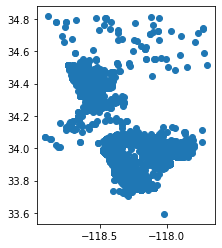

In [329]:
geowells.plot()

In [330]:
wellsIDLE=geowells.loc[geowells['WellStatus']=='Idle']
wellsIDLE.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3617 entries, 2 to 24232
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   LeaseName   3617 non-null   object  
 1   WellNumber  3617 non-null   object  
 2   WellStatus  3617 non-null   object  
 3   WellType    3617 non-null   object  
 4   WellTypeLa  3617 non-null   object  
 5   OperatorCo  3617 non-null   object  
 6   OperatorNa  3617 non-null   object  
 7   Latitude    3617 non-null   float64 
 8   Longitude   3617 non-null   float64 
 9   geometry    3617 non-null   geometry
dtypes: float64(2), geometry(1), object(7)
memory usage: 310.8+ KB


In [331]:
# testing
wellsIDLE.sample(5)

,LeaseName,WellNumber,WellStatus,WellType,WellTypeLa,OperatorCo,OperatorNa,Latitude,Longitude,geometry
17308,Vickers 2,35,Idle,OG,Oil & Gas,S2641,Sentinel Peak Resources California LLC,34.008778,-118.386764,POINT (-118.38676 34.00878)
7241,Lovelady,1,Idle,OG,Oil & Gas,8457,Three for One Special,33.801697,-118.175865,POINT (-118.17587 33.80170)
5384,WTU,2222,Idle,OG,Oil & Gas,W0325,"Warren E&P, Inc.",33.782284,-118.255493,POINT (-118.25549 33.78228)
4597,N-3-C,S-004,Idle,OG,Oil & Gas,C0883,"California Resources Long Beach, Inc.",33.775173,-118.206505,POINT (-118.20650 33.77517)
7215,Schilling,5,Idle,OG,Oil & Gas,S3625,"Signal Hill Petroleum, Inc.",33.801552,-118.172325,POINT (-118.17233 33.80155)


## Bring in Census Data

In [332]:
# now lets bring in the census tracts using the ACS 2019 five yr data
tracts=gpd.read_file('acs2019.geojson')

In [333]:
tracts.sample()

,geoid,name,B02001001,"B02001001, Error",B02001002,"B02001002, Error",B02001003,"B02001003, Error",B02001004,"B02001004, Error",...,"B02001006, Error",B02001007,"B02001007, Error",B02001008,"B02001008, Error",B02001009,"B02001009, Error",B02001010,"B02001010, Error",geometry
220,14000US06037127400,"Census Tract 1274, Los Angeles, CA",6558.0,614.0,2489.0,536.0,107.0,74.0,16.0,25.0,...,17.0,3512.0,694.0,166.0,98.0,63.0,49.0,103.0,90.0,"MULTIPOLYGON (((-118.48588 34.20832, -118.4858..."


In [334]:
# trim the data to the bare minimum columns
tracts = tracts[['geoid', 'name', 'geometry']]

In [335]:
tracts.sample()

,geoid,name,geometry
1342,14000US06037460301,"Census Tract 4603.01, Los Angeles, CA","MULTIPOLYGON (((-118.17895 34.21968, -118.1781..."


In [336]:
# drop the beginning of the geoid to make it match the FIPS column in the stats sheet
tracts['geoid'] = tracts['geoid'].str.replace('14000US','')
tracts.tail()

,geoid,name,geometry
2342,06037980033,"Census Tract 9800.33, Los Angeles, CA","MULTIPOLYGON (((-118.24897 33.75590, -118.2470..."
2343,06037990100,"Census Tract 9901, Los Angeles, CA","MULTIPOLYGON (((-118.95114 33.99643, -118.9505..."
2344,06037990200,"Census Tract 9902, Los Angeles, CA","MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."
2345,06037990300,"Census Tract 9903, Los Angeles, CA","MULTIPOLYGON (((-118.47656 33.75038, -118.4661..."
2346,16000US0644000,"Los Angeles, CA","MULTIPOLYGON (((-118.66818 34.18987, -118.6681..."


In [337]:
tracts=tracts.drop(2346)


In [338]:
tracts.columns = ['FIPS', 'name', 'geometry']

In [339]:
tracts.sample()

,FIPS,name,geometry
132,06037119320,"Census Tract 1193.20, Los Angeles, CA","MULTIPOLYGON (((-118.45772 34.23549, -118.4576..."


In [340]:
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2346 entries, 0 to 2345
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FIPS      2346 non-null   object  
 1   name      2346 non-null   object  
 2   geometry  2346 non-null   geometry
dtypes: geometry(1), object(2)
memory usage: 73.3+ KB


In [341]:
# converting the FIPS from an object to an int64
tracts.FIPS=tracts.FIPS.astype(int)

In [342]:
# checking
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2346 entries, 0 to 2345
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FIPS      2346 non-null   int64   
 1   name      2346 non-null   object  
 2   geometry  2346 non-null   geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 73.3+ KB


In [343]:
# now to bring in race data
stats = pd.read_csv('acs2019 five year stats.csv')

In [344]:
stats.sample(5)

,FIPS,Area Name,Census Tract,Total Population:,Total: White,Total: Black,Total: AmerIndian,Total: Asian,Total: Hawaiian and PacIslander,Total: Other,...,% Total: Black,% Total: AmerIndian,% Total: Asian,% Total: Hawaiian and PacIslander,% Total: Other,% Total: Mixed,Total: Not Hispanic or Latino,Total: Hispanic or Latino,% Total: Not Hispanic or Latino,% Total: Hispanic or Latino
859,6037267200,Census Tract 2672,267200,7004,4997,274,0,1125,13,138,...,3.91,0.00,16.06,0.19,1.97,6.52,6540,464,93.38,6.62
14,6037103400,Census Tract 1034,103400,6416,4605,154,114,1050,0,299,...,2.40,1.78,16.37,0.00,4.66,3.02,4843,1573,75.48,24.52
787,6037239320,Census Tract 2393.20,239320,4086,1202,440,147,31,0,2093,...,10.77,3.60,0.76,0.00,51.22,4.23,635,3451,15.54,84.46
1609,6037534102,Census Tract 5341.02,534102,6219,5066,109,0,17,0,1027,...,1.75,0.00,0.27,0.00,16.51,0.00,94,6125,1.51,98.49
1630,6037535200,Census Tract 5352,535200,6111,2768,778,0,0,0,2285,...,12.73,0.00,0.00,0.00,37.39,4.58,725,5386,11.86,88.14


In [345]:
# making sure out FIPS codes match types
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   FIPS                               2346 non-null   int64  
 1   Area Name                          2346 non-null   object 
 2   Census Tract                       2346 non-null   int64  
 3   Total Population:                  2346 non-null   int64  
 4   Total: White                       2346 non-null   int64  
 5   Total: Black                       2346 non-null   int64  
 6   Total: AmerIndian                  2346 non-null   int64  
 7   Total: Asian                       2346 non-null   int64  
 8   Total: Hawaiian and PacIslander    2346 non-null   int64  
 9   Total: Other                       2346 non-null   int64  
 10  Total: Mixed                       2346 non-null   int64  
 11  % Total: White                     2327 non-null   float

In [346]:
# check the size of each dataset
print(tracts.shape)
print(stats.shape)

(2346, 3)
(2346, 22)


In [347]:
# merge the datasets
merged = tracts.merge(stats, # left dataset = shapes, right dataset = district ID's
                                                    on='FIPS', # the column to merge with
                                                    how='left', # use a left outer join, which means all of the entries in expulsions will be preserved
                                                    indicator=True) # create a new column '_merge' that tells us how the merge went


In [348]:
# check the size of each dataset
print(merged.shape)

(2346, 25)


In [349]:
#drop the extra column
merged = merged.drop(labels='_merge',axis='columns')
merged.sample(7)

,FIPS,name,geometry,Area Name,Census Tract,Total Population:,Total: White,Total: Black,Total: AmerIndian,Total: Asian,...,% Total: Black,% Total: AmerIndian,% Total: Asian,% Total: Hawaiian and PacIslander,% Total: Other,% Total: Mixed,Total: Not Hispanic or Latino,Total: Hispanic or Latino,% Total: Not Hispanic or Latino,% Total: Hispanic or Latino
1454,6037500201,"Census Tract 5002.01, Los Angeles, CA","MULTIPOLYGON (((-117.99430 33.94477, -117.9941...",Census Tract 5002.01,500201,7267,5592,29,0,549,...,0.40,0.00,7.55,0.00,11.41,3.69,5056,2211,69.57,30.43
1582,6037533106,"Census Tract 5331.06, Los Angeles, CA","MULTIPOLYGON (((-118.22130 33.97927, -118.2210...",Census Tract 5331.06,533106,1655,1351,0,56,0,...,0.00,3.38,0.00,0.00,12.39,2.60,53,1602,3.20,96.80
1010,6037301602,"Census Tract 3016.02, Los Angeles, CA","MULTIPOLYGON (((-118.30781 34.16114, -118.3071...",Census Tract 3016.02,301602,4446,3216,137,0,510,...,3.08,0.00,11.47,1.15,9.42,2.54,2651,1795,59.63,40.37
1145,6037403500,"Census Tract 4035, Los Angeles, CA","MULTIPOLYGON (((-117.87230 34.07170, -117.8713...",Census Tract 4035,403500,1835,892,52,28,699,...,2.83,1.53,38.09,0.00,2.94,5.99,1174,661,63.98,36.02
401,6037189202,"Census Tract 1892.02, Los Angeles, CA","MULTIPOLYGON (((-118.30155 34.11272, -118.3015...",Census Tract 1892.02,189202,2396,1950,30,0,194,...,1.25,0.00,8.10,0.00,3.92,5.34,2212,184,92.32,7.68
145,6037120105,"Census Tract 1201.05, Los Angeles, CA","MULTIPOLYGON (((-118.45025 34.23178, -118.4502...",Census Tract 1201.05,120105,2832,917,41,33,483,...,1.45,1.17,17.06,0.00,47.00,0.95,679,2153,23.98,76.02
1452,6037482800,"Census Tract 4828, Los Angeles, CA","MULTIPOLYGON (((-118.13050 34.03679, -118.1304...",Census Tract 4828,482800,4524,752,115,37,2383,...,2.54,0.82,52.67,0.22,22.97,4.16,2712,1812,59.95,40.05


In [350]:
merged.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

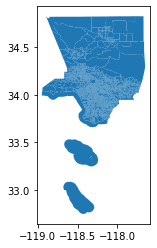

In [351]:
merged.plot()

<AxesSubplot:>

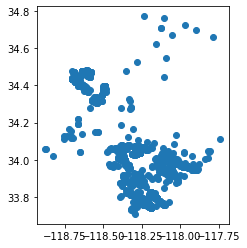

In [352]:
wellsIDLE.plot()

## Spatial Join - Idle Wells and Census Data

In [353]:
wellsIdleFIPS = gpd.sjoin(wellsIDLE, merged, how='left', op='intersects')
wellsIdleFIPS.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3617 entries, 2 to 24232
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   LeaseName                          3617 non-null   object  
 1   WellNumber                         3617 non-null   object  
 2   WellStatus                         3617 non-null   object  
 3   WellType                           3617 non-null   object  
 4   WellTypeLa                         3617 non-null   object  
 5   OperatorCo                         3617 non-null   object  
 6   OperatorNa                         3617 non-null   object  
 7   Latitude                           3617 non-null   float64 
 8   Longitude                          3617 non-null   float64 
 9   geometry                           3617 non-null   geometry
 10  index_right                        3615 non-null   float64 
 11  FIPS                              

## Summarize Well Counts per Census Tract

In [354]:
IdleWellCountsSummary = wellsIdleFIPS.FIPS.value_counts().rename_axis('FIPS').reset_index(name='counts')

In [355]:
IdleWellCountsSummary.head()

,FIPS,counts
0,6.037980e+09,291
1,6.037573e+09,184
2,6.037920e+09,169
3,6.037208e+09,158
4,6.037980e+09,133


In [356]:
# note only 287 census tracts contain wells
IdleWellCountsSummary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FIPS    287 non-null    float64
 1   counts  287 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 4.6 KB


## Re-join Well Counts to Census Tract Data

In [357]:
# merge the datasets
TractIdleWellCounts = merged.merge(IdleWellCountsSummary, # left dataset = census tract shapes, right dataset = well counts
                                                    on='FIPS', # the column to merge with
                                                    how='left', # use a left outer join, which means all of the entries in expulsions will be preserved
                                                    indicator=True) # create a new column '_merge' that tells us how the merge went


In [358]:
TractIdleWellCounts._merge.value_counts()

left_only     2059
both           287
right_only       0
Name: _merge, dtype: int64

In [359]:
# drop the extra column
TractIdleWellCounts = TractIdleWellCounts.drop(labels='_merge',axis='columns')
TractIdleWellCounts.sample(5)

,FIPS,name,geometry,Area Name,Census Tract,Total Population:,Total: White,Total: Black,Total: AmerIndian,Total: Asian,...,% Total: AmerIndian,% Total: Asian,% Total: Hawaiian and PacIslander,% Total: Other,% Total: Mixed,Total: Not Hispanic or Latino,Total: Hispanic or Latino,% Total: Not Hispanic or Latino,% Total: Hispanic or Latino,counts
326,6037139702,"Census Tract 1397.02, Los Angeles, CA","MULTIPOLYGON (((-118.52971 34.12945, -118.5296...",Census Tract 1397.02,139702,6447,5774,214,0,247,...,0.00,3.83,0.0,1.15,2.14,6160,287,95.55,4.45,NaN
443,6037191901,"Census Tract 1919.01, Los Angeles, CA","MULTIPOLYGON (((-118.34406 34.08889, -118.3440...",Census Tract 1919.01,191901,3060,2009,234,12,147,...,0.39,4.80,0.0,13.46,8.04,2247,813,73.43,26.57,NaN
1685,6037542105,"Census Tract 5421.05, Los Angeles, CA","MULTIPOLYGON (((-118.20261 33.89607, -118.2016...",Census Tract 5421.05,542105,4781,2134,633,63,0,...,1.32,0.00,0.0,39.78,1.02,775,4006,16.21,83.79,NaN
1960,6037601001,"Census Tract 6010.01, Los Angeles, CA","MULTIPOLYGON (((-118.35337 33.96539, -118.3533...",Census Tract 6010.01,601001,2381,670,1446,12,17,...,0.50,0.71,0.0,5.50,4.41,1581,800,66.40,33.60,2.0
224,6037127605,"Census Tract 1276.05, Los Angeles, CA","MULTIPOLYGON (((-118.49020 34.19390, -118.4870...",Census Tract 1276.05,127605,4329,911,108,26,336,...,0.60,7.76,0.0,65.60,2.49,971,3358,22.43,77.57,NaN


In [360]:
# replace NaN with 0
TractIdleWellCounts.counts = TractIdleWellCounts.counts.fillna(0)
TractIdleWellCounts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2346 entries, 0 to 2345
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   FIPS                               2346 non-null   int64   
 1   name                               2346 non-null   object  
 2   geometry                           2346 non-null   geometry
 3   Area Name                          2346 non-null   object  
 4   Census Tract                       2346 non-null   int64   
 5   Total Population:                  2346 non-null   int64   
 6   Total: White                       2346 non-null   int64   
 7   Total: Black                       2346 non-null   int64   
 8   Total: AmerIndian                  2346 non-null   int64   
 9   Total: Asian                       2346 non-null   int64   
 10  Total: Hawaiian and PacIslander    2346 non-null   int64   
 11  Total: Other                       

## Now we plot the data!

In [361]:
def plotly_scatter_wellCounts(xcol = '% Total: White', ycol = 'counts',df = TractIdleWellCounts):
    # a simple scatter plot
    fig = px.scatter(df,
                     x = xcol,
                     y= ycol,
                     title='Number of Idle Wells in Census Tract'
          )

    # show the figure
    fig.show()


In [362]:
columns_of_interest = ['% Total: White', '% Total: Black',
       '% Total: AmerIndian', '% Total: Asian',
       '% Total: Hawaiian and PacIslander', '% Total: Other', '% Total: Mixed',
       '% Total: Not Hispanic or Latino', '% Total: Hispanic or Latino']

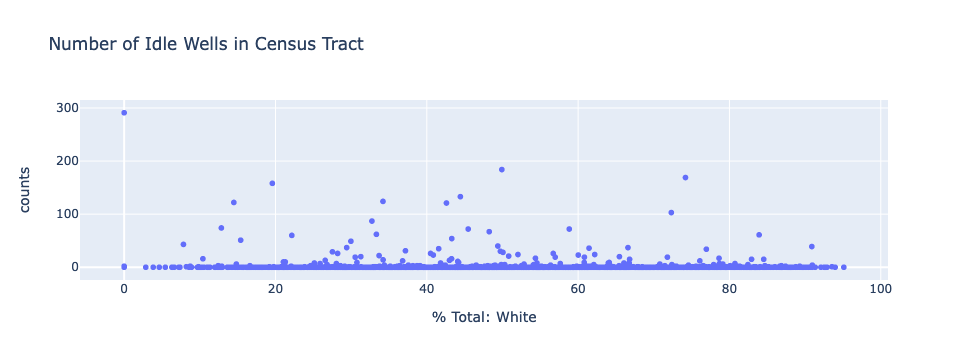

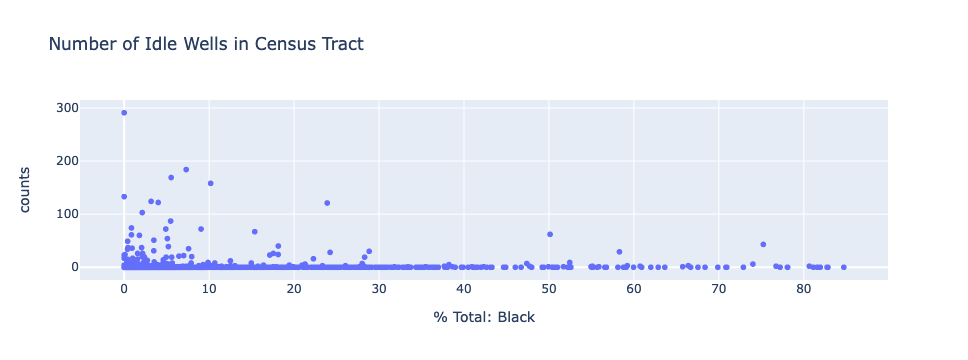

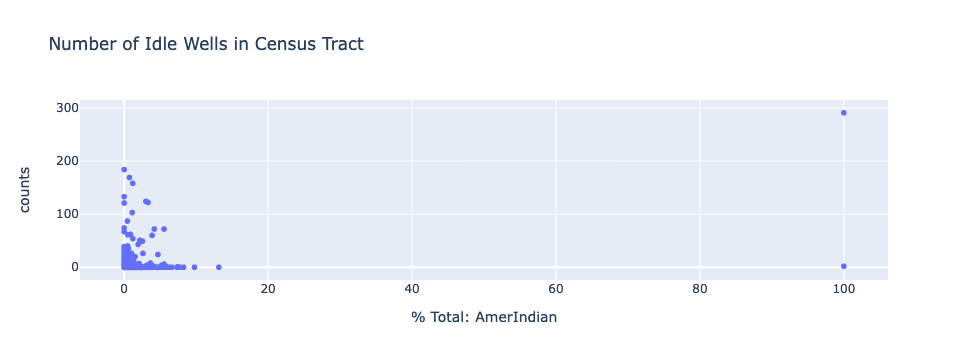

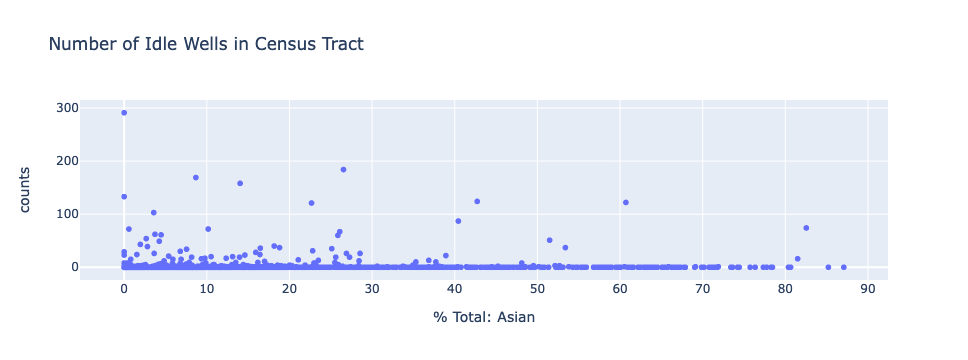

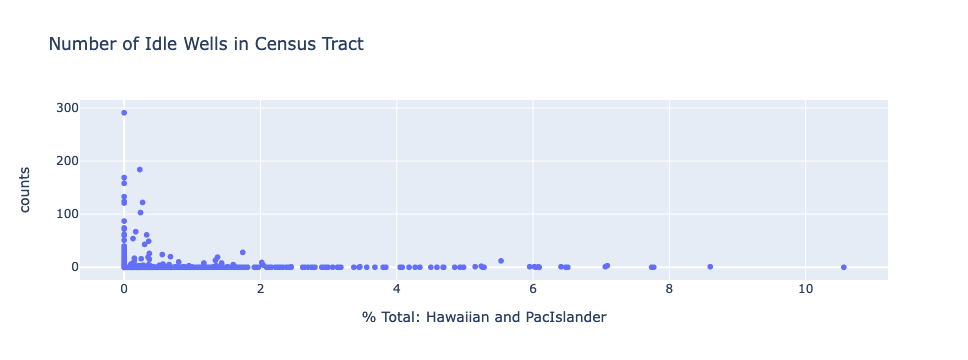

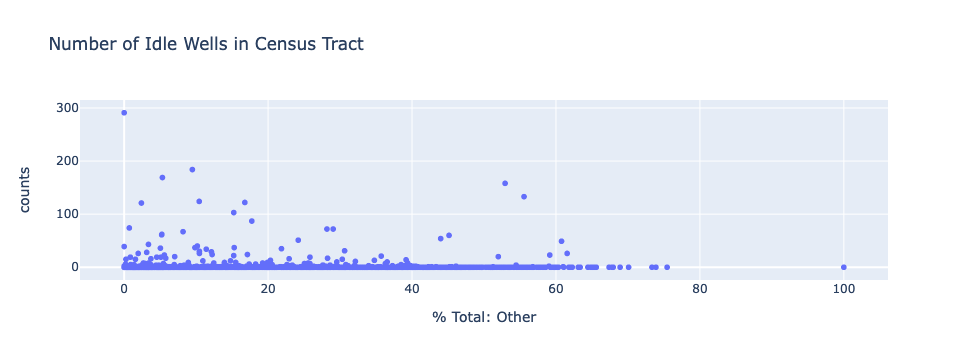

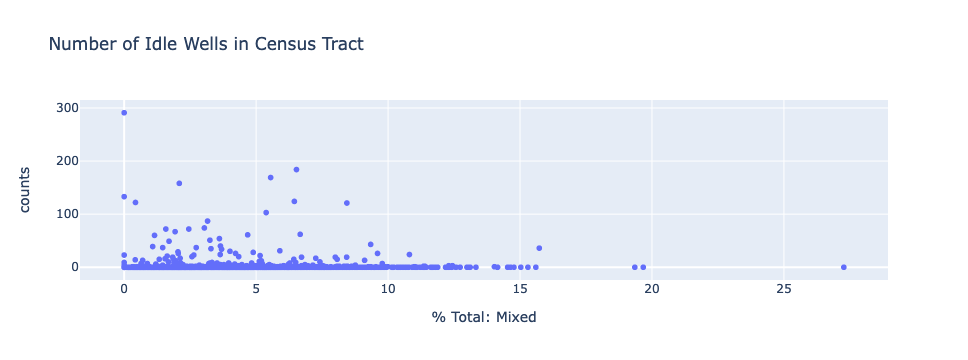

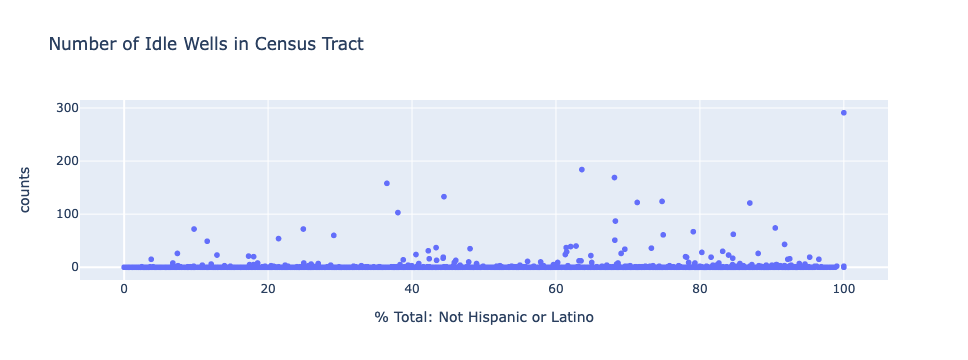

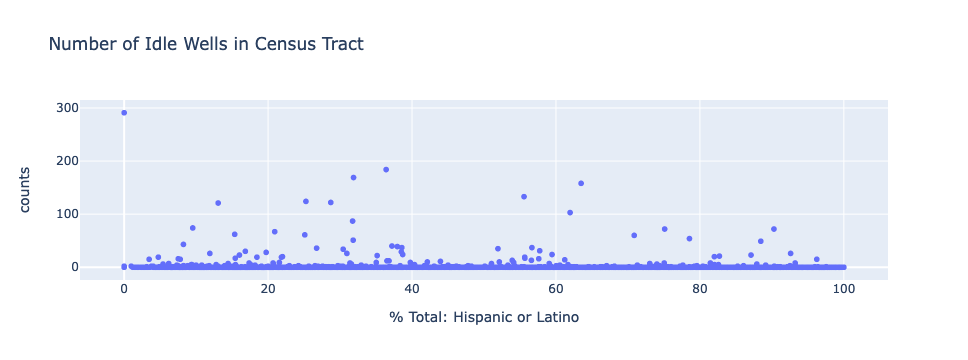

In [363]:
for col in columns_of_interest:
    plotly_scatter(xcol = col)